In [2]:
# !pip install geopandas folium matplotlib seaborn scipy
# !pip install esda
# !pip install splot
# # for google colab, had to reinstall some pacakges.

In [3]:
import pandas as pd
import geopandas as gpd
import numpy as np
import datetime as dt
import scipy

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
from scipy import stats

# visualization
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import seaborn as sns
import folium
from folium.plugins import HeatMap
from folium import Marker
from folium.plugins import MarkerCluster
import plotly.express as px
import plotly.io as pio

# spatial statistics
from esda.moran import Moran
from esda.getisord import G_Local
from libpysal.weights import Queen, Rook

# system and utility
import warnings
import os
import io
from IPython.display import IFrame
from google.colab import files

from libpysal.weights import Queen, Rook
from esda.moran import Moran
import matplotlib.pyplot as plt
from splot.esda import moran_scatterplot

# suppress warnings
warnings.filterwarnings('ignore')

# inline
%matplotlib inline

In [190]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [196]:
# data source:
file_path1 = '/content/drive/My Drive/X999/bbl_evictions_merged.csv'
file_path3 = '/content/drive/My Drive/X999/bbl_cleaned.csv'
# file_path2 = '/content/drive/My Drive/X999/evictions_pre_post_covid.csv'

In [197]:
# evictions = pd.read_csv(file_path2)
bbl_cleaned = pd.read_csv(file_path3)

In [198]:
# list(bbl_cleaned.columns),
bbl_cleaned.shape
# so 753110 res buildings
# will use this number to calculate the average number of evictions per building, but not only the builingds that
# have the evictions, but all the res buildings

(753110, 112)

In [199]:
# evictions.eviction_count.sum()

In [200]:
bbl_evictions_merged_raw = pd.read_csv(file_path1)

In [201]:
bbl_evictions_merged = bbl_evictions_merged_raw.copy()

In [202]:
display(bbl_evictions_merged.head()), bbl_evictions_merged.shape

,court_index_number,docket_number,eviction_address,eviction_apartment_number,executed_date,borough,eviction_postcode,ejectment,eviction/legal_possession,latitude,...,is_condo,floor_category,rent_era,architectural_style,economic_period,residential_units_category,is_llc,building_size_category,size_quartile,decade
0,34859/16,53416,3476 SEYMOUR AVENUE,3-B,2017-01-03,BRONX,10469,Not an Ejectment,Possession,40.877620,...,False,mid-rise,"Pre-1947, pre-rent-control","1931–1950, Manhattan Modern","1930-1945, great depression and WWII",100+ units,True,mega,Q4 (largest 25%),1930-1939
1,B57808/16,74242,1426 BRYANT AVENUE,10 AKA 2ND FL UNIT,2017-01-03,BRONX,10459,Not an Ejectment,Possession,40.830691,...,False,low-rise,"1994–Present, vacancy decontrol","1981–2000, Post-Modernism","1991–2008, modern economic growth",2-unit,False,small,Q3 (50-75%),1990-1999
2,N069212/14,355977,1309 5TH AVENUE,24H,2017-01-03,MANHATTAN,10029,Not an Ejectment,Possession,40.797309,...,False,high-rise,"1970–1993, deregularization","1951–1980, the International Style, Alternativ...","1946–1975, pst war economic boom",100+ units,False,mega,Q4 (largest 25%),1970-1979
3,K065455/16,367441,458 EAST 51 STREET,6A,2017-01-03,BROOKLYN,11203,Not an Ejectment,Possession,40.650624,...,False,mid-rise,"Pre-1947, pre-rent-control","1931–1950, Manhattan Modern","1930-1945, great depression and WWII",21-100 units,True,very large,Q4 (largest 25%),1940-1949
4,33992/16,458984,580 EAST 168TH STREE T,*,2017-01-03,BRONX,10456,Not an Ejectment,Possession,40.830494,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(None, (74082, 40))

In [203]:
type(bbl_evictions_merged.executed_date[0]), bbl_evictions_merged.executed_date[0]
bbl_evictions_merged['executed_date'] = pd.to_datetime(bbl_evictions_merged['executed_date'], format='%Y-%m-%d')
bbl_evictions_merged['executed_date'].dt.year.unique() # 5 years

array([2017, 2018, 2019, 2023, 2024], dtype=int32)

In [204]:
bbl_evictions_merged.columns

Index(['court_index_number', 'docket_number', 'eviction_address',
       'eviction_apartment_number', 'executed_date', 'borough',
       'eviction_postcode', 'ejectment', 'eviction/legal_possession',
       'latitude', 'longitude', 'community_board', 'council_district',
       'census_tract', 'bin', 'bbl', 'nta', 'geometry', 'eviction_count',
       'year', 'average_year_eviction_count', 'bbl_clean', 'yearbuilt',
       'bldgclass', 'numfloors', 'unitsres', 'ownername', 'bldgarea',
       'building_type', 'building_category', 'is_condo', 'floor_category',
       'rent_era', 'architectural_style', 'economic_period',
       'residential_units_category', 'is_llc', 'building_size_category',
       'size_quartile', 'decade'],
      dtype='object')

In [205]:
building_characteristics = [
    'yearbuilt', 'bldgclass', 'numfloors', 'unitsres', 'ownername', 'bldgarea',
    'building_type', 'building_category', 'is_condo', 'floor_category',
    'rent_era', 'architectural_style', 'economic_period',
    'residential_units_category', 'is_llc', 'building_size_category',
    'size_quartile', 'yearbuilt', 'numfloors', 'unitsres', 'decade'
]

In [206]:
nan_counts = bbl_evictions_merged[building_characteristics].isna().sum()
nan_percentages = (nan_counts / len(bbl_evictions_merged) * 100).round(3)
# percentage:.3f%

In [207]:
nan_counts, nan_percentages

(yearbuilt                     3770
 bldgclass                     3770
 numfloors                     3770
 unitsres                      3770
 ownername                     3770
 bldgarea                      3770
 building_type                 3770
 building_category             3770
 is_condo                      3770
 floor_category                3770
 rent_era                      3770
 architectural_style           3770
 economic_period               3770
 residential_units_category    3770
 is_llc                        3770
 building_size_category        3770
 size_quartile                 3770
 yearbuilt                     3770
 numfloors                     3770
 unitsres                      3770
 decade                        3773
 dtype: int64,
 yearbuilt                     5.089
 bldgclass                     5.089
 numfloors                     5.089
 unitsres                      5.089
 ownername                     5.089
 bldgarea                      5.089
 buildi

In [208]:
bbl_evictions_merged.shape

(74082, 40)

In [209]:
df = bbl_evictions_merged.copy()

In [210]:
df = bbl_evictions_merged.dropna(subset=['average_year_eviction_count'])

In [211]:
df.shape

(74082, 40)

In [212]:
df_clean = df.dropna(subset=building_characteristics)

In [213]:
df_clean.shape, 74082 - 70312
# good

((70309, 40), 3770)

In [214]:
df_clean['eviction_rate_per_unit'] = df_clean['average_year_eviction_count'] / df_clean['unitsres']
df_clean['eviction_rate_per_unit'] = df_clean['eviction_rate_per_unit'].replace([np.inf, -np.inf], np.nan)
# second line handles potential division by zero errors

In [215]:
display(df_clean.head())

,court_index_number,docket_number,eviction_address,eviction_apartment_number,executed_date,borough,eviction_postcode,ejectment,eviction/legal_possession,latitude,...,floor_category,rent_era,architectural_style,economic_period,residential_units_category,is_llc,building_size_category,size_quartile,decade,eviction_rate_per_unit
0,34859/16,53416,3476 SEYMOUR AVENUE,3-B,2017-01-03,BRONX,10469,Not an Ejectment,Possession,40.877620,...,mid-rise,"Pre-1947, pre-rent-control","1931–1950, Manhattan Modern","1930-1945, great depression and WWII",100+ units,True,mega,Q4 (largest 25%),1930-1939,0.016456
1,B57808/16,74242,1426 BRYANT AVENUE,10 AKA 2ND FL UNIT,2017-01-03,BRONX,10459,Not an Ejectment,Possession,40.830691,...,low-rise,"1994–Present, vacancy decontrol","1981–2000, Post-Modernism","1991–2008, modern economic growth",2-unit,False,small,Q3 (50-75%),1990-1999,0.500000
2,N069212/14,355977,1309 5TH AVENUE,24H,2017-01-03,MANHATTAN,10029,Not an Ejectment,Possession,40.797309,...,high-rise,"1970–1993, deregularization","1951–1980, the International Style, Alternativ...","1946–1975, pst war economic boom",100+ units,False,mega,Q4 (largest 25%),1970-1979,0.006667
3,K065455/16,367441,458 EAST 51 STREET,6A,2017-01-03,BROOKLYN,11203,Not an Ejectment,Possession,40.650624,...,mid-rise,"Pre-1947, pre-rent-control","1931–1950, Manhattan Modern","1930-1945, great depression and WWII",21-100 units,True,very large,Q4 (largest 25%),1940-1949,0.050314
6,50104/16,318266,598 E 183 ST AKA 2239 ADAMS PL,26,2017-01-03,BRONX,10457,Not an Ejectment,Possession,40.853070,...,mid-rise,"Pre-1947, pre-rent-control","1900–1920, Beaux-Arts","Pre-1929, pre-great depression",21-100 units,True,very large,Q4 (largest 25%),1900-1909,0.060345


In [216]:
building_evictions = df.groupby('bbl_clean').agg({
    'average_year_eviction_count': 'mean',
    'eviction_count': 'sum',
    'unitsres': 'first',
    'decade': 'first',
    'building_category': 'first',
    'building_type': 'first',
    'is_llc': 'first',
    'yearbuilt': 'first',
    'bldgclass': 'first',
    'numfloors': 'first',
    'bldgarea': 'first',
    'is_condo': 'first',
    'floor_category': 'first',
    'rent_era': 'first',
    'architectural_style': 'first',
    'economic_period': 'first',
    'residential_units_category': 'first',
    'building_size_category': 'first',
    'size_quartile': 'first'
}).reset_index()
building_evictions['eviction_rate_per_unit'] = building_evictions['average_year_eviction_count'] / building_evictions['unitsres']

In [217]:
characteristics = [
    'yearbuilt', 'bldgclass', 'numfloors', 'unitsres', 'bldgarea',
    'building_type', 'building_category', 'is_condo', 'floor_category',
    'rent_era', 'architectural_style', 'economic_period',
    'residential_units_category', 'is_llc', 'building_size_category',
    'size_quartile'
]
characteristics = list(dict.fromkeys(characteristics))
building_evictions['eviction_rate_per_unit'] = building_evictions['eviction_rate_per_unit'].replace([np.inf, -np.inf], np.nan)
building_evictions_clean = building_evictions.dropna(subset=['eviction_rate_per_unit'])
current_year = pd.Timestamp.now().year
building_evictions_clean['building_age'] = current_year - building_evictions_clean['yearbuilt']
characteristics.append('building_age')

In [218]:
current_year = pd.Timestamp.now().year
bbl_cleaned['building_age'] = current_year - bbl_cleaned['yearbuilt']

In [219]:
print(f"total buildings analyzed: {len(building_evictions_clean)}")
print(f"average eviction rate per unit: {building_evictions_clean['eviction_rate_per_unit'].mean():.4f}")

total buildings analyzed: 31545
average eviction rate per unit: 0.3094


In [220]:
numerical_chars = building_evictions_clean[characteristics].select_dtypes(include=[np.number]).columns.tolist()
numerical_chars

['yearbuilt', 'numfloors', 'unitsres', 'bldgarea', 'building_age']

In [221]:
"building_age" in bbl_cleaned.columns, "building_age" in building_evictions_clean.columns

(True, True)

In [222]:
"bbl_cleaned" in bbl_cleaned.columns

False

In [223]:
building_evictions_clean.columns

Index(['bbl_clean', 'average_year_eviction_count', 'eviction_count',
       'unitsres', 'decade', 'building_category', 'building_type', 'is_llc',
       'yearbuilt', 'bldgclass', 'numfloors', 'bldgarea', 'is_condo',
       'floor_category', 'rent_era', 'architectural_style', 'economic_period',
       'residential_units_category', 'building_size_category', 'size_quartile',
       'eviction_rate_per_unit', 'building_age'],
      dtype='object')

In [224]:
print(bbl_cleaned.columns.tolist())
print(building_evictions_clean.columns.tolist())

['borough', 'block', 'lot', 'community board', 'census tract 2010', 'cb2010', 'schooldist', 'council district', 'postcode', 'firecomp', 'policeprct', 'healtharea', 'sanitboro', 'sanitsub', 'address', 'zonedist1', 'zonedist2', 'zonedist3', 'zonedist4', 'overlay1', 'overlay2', 'spdist1', 'spdist2', 'spdist3', 'ltdheight', 'splitzone', 'bldgclass', 'landuse', 'easements', 'ownertype', 'ownername', 'lotarea', 'bldgarea', 'comarea', 'resarea', 'officearea', 'retailarea', 'garagearea', 'strgearea', 'factryarea', 'otherarea', 'areasource', 'numbldgs', 'numfloors', 'unitsres', 'unitstotal', 'lotfront', 'lotdepth', 'bldgfront', 'bldgdepth', 'ext', 'proxcode', 'irrlotcode', 'lottype', 'bsmtcode', 'assessland', 'assesstot', 'exempttot', 'yearbuilt', 'yearalter1', 'yearalter2', 'histdist', 'landmark', 'builtfar', 'residfar', 'commfar', 'facilfar', 'borocode', 'bbl', 'condono', 'tract2010', 'xcoord', 'ycoord', 'latitude', 'longitude', 'zonemap', 'zmcode', 'sanborn', 'taxmap', 'edesignum', 'appbbl',

In [225]:
building_evictions_clean.columns

Index(['bbl_clean', 'average_year_eviction_count', 'eviction_count',
       'unitsres', 'decade', 'building_category', 'building_type', 'is_llc',
       'yearbuilt', 'bldgclass', 'numfloors', 'bldgarea', 'is_condo',
       'floor_category', 'rent_era', 'architectural_style', 'economic_period',
       'residential_units_category', 'building_size_category', 'size_quartile',
       'eviction_rate_per_unit', 'building_age'],
      dtype='object')

In [226]:
building_evictions_clean['evictions_per_unit'] = building_evictions_clean['average_year_eviction_count'] / building_evictions_clean['unitsres']
building_evictions_clean['evictions_per_100_units'] = (building_evictions_clean['average_year_eviction_count'] / building_evictions_clean['unitsres']) * 100

In [227]:
display(building_evictions_clean.head(5))

,bbl_clean,average_year_eviction_count,eviction_count,unitsres,decade,building_category,building_type,is_llc,yearbuilt,bldgclass,...,rent_era,architectural_style,economic_period,residential_units_category,building_size_category,size_quartile,eviction_rate_per_unit,building_age,evictions_per_unit,evictions_per_100_units
4,1000160015,1.0,2,208.0,1990-1999,elevator,post-war,False,1998.0,D8,...,"1994–Present, vacancy decontrol","1981–2000, Post-Modernism","1991–2008, modern economic growth",100+ units,mega,Q4 (largest 25%),0.004808,27.0,0.004808,0.480769
5,1000160020,1.0,4,209.0,1990-1999,elevator,post-war,True,1998.0,D8,...,"1994–Present, vacancy decontrol","1981–2000, Post-Modernism","1991–2008, modern economic growth",100+ units,mega,Q4 (largest 25%),0.004785,27.0,0.004785,0.478469
6,1000160100,5.4,810,1712.0,1980-1989,elevator,post-war,False,1983.0,D6,...,"1970–1993, deregularization","1981–2000, Post-Modernism","1976–1990, fiscal crisis and recovery",100+ units,mega,Q4 (largest 25%),0.003154,42.0,0.003154,0.315421
7,1000160180,1.0,9,293.0,2000-2009,elevator,post-war,False,2002.0,D8,...,"1994–Present, vacancy decontrol","2001-present, New Architecture","1991–2008, modern economic growth",100+ units,mega,Q4 (largest 25%),0.003413,23.0,0.003413,0.341297
8,1000160185,2.0,4,253.0,2000-2009,elevator,post-war,True,2004.0,D8,...,"1994–Present, vacancy decontrol","2001-present, New Architecture","1991–2008, modern economic growth",100+ units,mega,Q4 (largest 25%),0.007905,21.0,0.007905,0.790514


In [228]:
building_evictions_clean.columns

Index(['bbl_clean', 'average_year_eviction_count', 'eviction_count',
       'unitsres', 'decade', 'building_category', 'building_type', 'is_llc',
       'yearbuilt', 'bldgclass', 'numfloors', 'bldgarea', 'is_condo',
       'floor_category', 'rent_era', 'architectural_style', 'economic_period',
       'residential_units_category', 'building_size_category', 'size_quartile',
       'eviction_rate_per_unit', 'building_age', 'evictions_per_unit',
       'evictions_per_100_units'],
      dtype='object')

In [229]:
corr = building_evictions_clean['building_age'].corr(building_evictions_clean['average_year_eviction_count'], method='pearson')
corr

0.004266969001611567

## Categorical analysis:

### Consolidated Function:

In [230]:
def build_category_dataframes(bbl_cleaned, cleaned_dataframe, category_column, num_years=5):
    category_data = cleaned_dataframe.groupby(category_column).agg(
        total_evictions=('eviction_count', 'count')
    ).reset_index()
    total_evictions = category_data['total_evictions'].sum()
    category_data['eviction_percentage'] = category_data['total_evictions'] / total_evictions
    total_building_count = 753110

    building_counts = bbl_cleaned['bbl'].groupby(bbl_cleaned[category_column]).nunique()
    building_counts_df = bbl_cleaned.groupby(category_column)['bbl'].nunique().reset_index()
    building_counts_df.columns = [category_column, 'building_count']
    total_buildings = building_counts_df.building_count.sum()
    building_counts_df['building_percentage'] = (building_counts_df['building_count'] / total_buildings) * 100

    category_data = pd.merge(category_data, building_counts_df, on=category_column)

    # category_data['evictions_per_building'] = category_data['total_evictions'] / category_data['building_count']
    num_years = 5  # outside of covid
    category_data['yearly_evictions_per_cat'] = category_data['total_evictions'] / num_years
    # print('before changes')
    evictions_per_100_by_category = cleaned_dataframe.groupby(category_column)['evictions_per_100_units'].mean().reset_index()
    category_data = pd.merge(category_data, evictions_per_100_by_category, on=category_column)
    category_data['yearly_evictions_per_100unit'] = category_data['evictions_per_100_units'] / num_years


    return category_data

### 2. Building Type: Pre/Post-war

In [231]:
category_data = build_category_dataframes(bbl_cleaned, building_evictions_clean, 'building_type')
category_data

,building_type,total_evictions,eviction_percentage,building_count,building_percentage,yearly_evictions_per_cat,evictions_per_100_units,yearly_evictions_per_100unit
0,post-war,8801,0.278998,290789,38.611757,1760.2,34.844001,6.968800
1,pre-war,22744,0.721002,462321,61.388243,4548.8,29.436018,5.887204


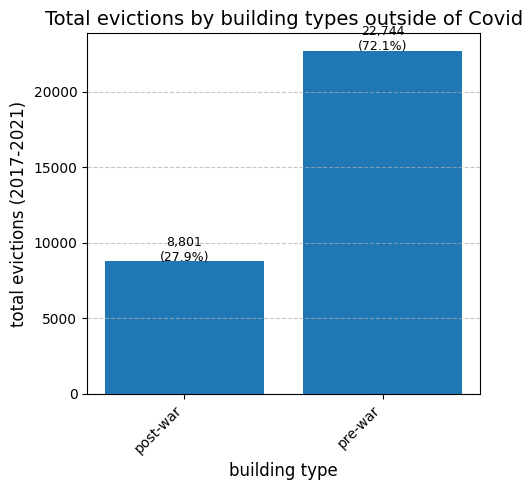

In [232]:
total_all_evictions = category_data['total_evictions'].sum()
# category_data['percentage'] = (category_data['total_evictions'] / total_all_evictions) * 100

plt.figure(figsize=(5, 5))
bars = plt.bar(category_data['building_type'], category_data['total_evictions'])
for i, (value, percentage) in enumerate(zip(category_data['total_evictions'],
                                           category_data['eviction_percentage']*100)):
    plt.text(i, value + (value * 0.0005),
             f"{value:,.0f}\n({percentage:.1f}%)",
             ha='center', fontsize=9)
plt.xlabel('building type', fontsize=12)
plt.ylabel('total evictions (2017-2021)', fontsize=12)
plt.title('Total evictions by building types outside of Covid', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

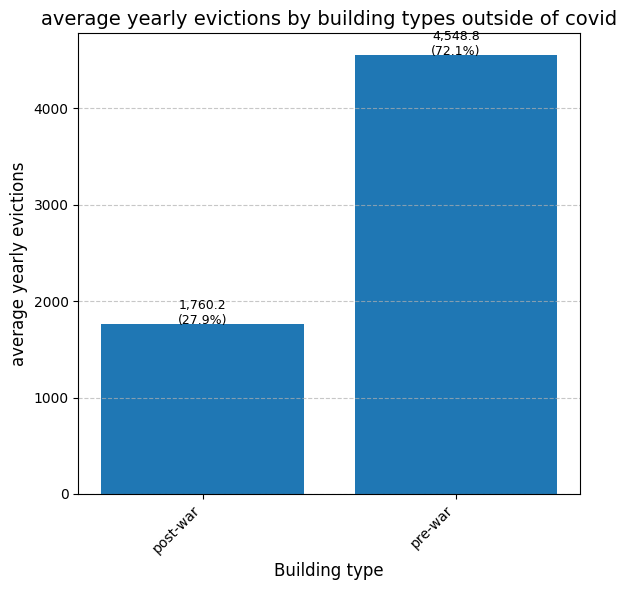

In [233]:
category_data['yearly_evictions'] = category_data['total_evictions'] / 5
total_yearly_evictions = category_data['yearly_evictions'].sum()
category_data['percentage'] = (category_data['yearly_evictions_per_cat'] / total_yearly_evictions) * 100

plt.figure(figsize=(6, 6))
bars = plt.bar(category_data['building_type'], category_data['yearly_evictions_per_cat'])
for i, (value, percentage) in enumerate(zip(category_data['yearly_evictions_per_cat'],
                                            category_data['percentage'])):
    plt.text(i, value + (value * 0.00005),
             f"{value:,.1f}\n({percentage:.1f}%)",
             ha='center', fontsize=9)
plt.xlabel('Building type', fontsize=12)
plt.ylabel('average yearly evictions', fontsize=12)
plt.title('average yearly evictions by building types outside of covid', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

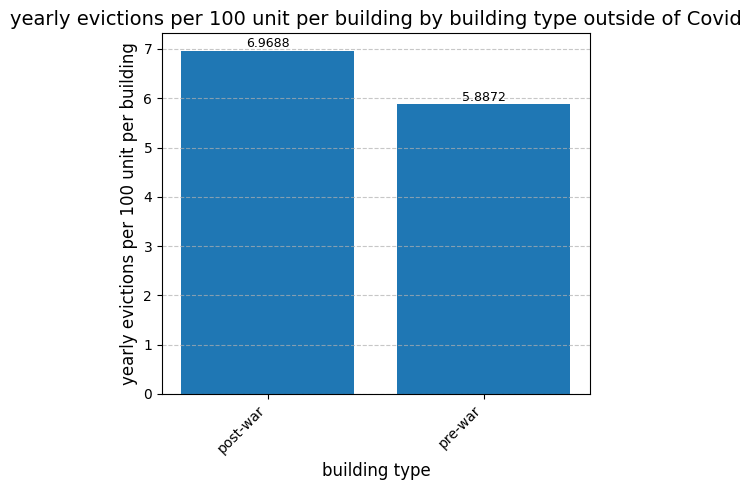

In [234]:
plt.figure(figsize=(5, 5))
bars = plt.bar(category_data['building_type'], category_data['yearly_evictions_per_100unit'])
for i, value in enumerate(category_data['yearly_evictions_per_100unit']):
    plt.text(i, value + (value * 0.01),
             f"{value:.4f}",
             ha='center', fontsize=9)

plt.xlabel('building type', fontsize=12)
plt.ylabel('yearly evictions per 100 unit per building', fontsize=12)
plt.title('yearly evictions per 100 unit per building by building type outside of Covid', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

In [235]:
print("ranked list of yearly evictions per building:")
sorted_data = category_data.sort_values('yearly_evictions_per_100unit', ascending=False)
for i in range(len(sorted_data)):
    category = sorted_data.iloc[i]['building_type']
    rate = sorted_data.iloc[i]['yearly_evictions_per_100unit']
    print(f"{i+1}. {category}: {rate:.4f}")

ranked list of yearly evictions per building:
1. post-war: 6.9688
2. pre-war: 5.8872


This means post-war buildings have about 18% higher eviction rates than pre-war buildings. This finding suggests that the era of construction (pre-war vs. post-war) is another factor that correlates with eviction patterns, though not as strongly as building size and height based the findings below. \
One explanation for the pre-war/post-war distinction might be the differences in construction quality, architectural design, tenant demographics, ownership patterns, or regulatory environments.

## 3. Architectural Style

In [236]:
category_data = build_category_dataframes(bbl_cleaned, building_evictions_clean, 'architectural_style')
category_data

,architectural_style,total_evictions,eviction_percentage,building_count,building_percentage,yearly_evictions_per_cat,evictions_per_100_units,yearly_evictions_per_100unit
0,"1900–1920, Beaux-Arts",9427,0.298843,182991,24.298044,1885.4,32.075260,6.415052
1,"1921–1930, Art Deco Skyscrapers",8052,0.255254,153977,20.445486,1610.4,26.189784,5.237957
2,"1931–1950, Manhattan Modern",5326,0.168838,157454,20.907172,1065.2,32.204302,6.440860
3,"1951–1980, the International Style, Alternativ...",3646,0.115581,122280,16.236672,729.2,28.000312,5.600062
4,"1981–2000, Post-Modernism",1128,0.035758,49603,6.586422,225.6,43.169129,8.633826
5,"2001-present, New Architecture",2916,0.092439,48716,6.468643,583.2,33.225348,6.645070
6,Pre-1900,1050,0.033286,38089,5.057561,210.0,41.630564,8.326113


In [237]:
category_data.architectural_style.unique()

array(['1900–1920, Beaux-Arts', '1921–1930, Art Deco Skyscrapers',
       '1931–1950, Manhattan Modern',
       '1951–1980, the International Style, Alternative Modernism',
       '1981–2000, Post-Modernism', '2001-present, New Architecture',
       'Pre-1900'], dtype=object)

In [238]:
order = ['Pre-1900', '1900–1920, Beaux-Arts', '1921–1930, Art Deco Skyscrapers', '1931–1950, Manhattan Modern',
         '1951–1980, the International Style, Alternative Modernism', '1981–2000, Post-Modernism', '2001-present, New Architecture']
category_data['architectural_style'] = pd.Categorical(category_data['architectural_style'], categories= order, ordered=True)
category_data = category_data.sort_values('architectural_style')

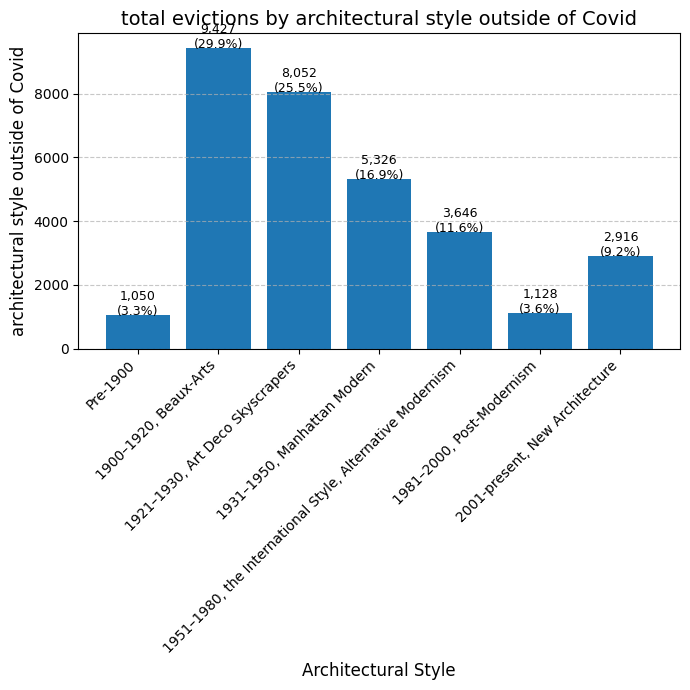

In [239]:
total_all_evictions = category_data['total_evictions'].sum()
# category_data['percentage'] = (category_data['total_evictions'] / total_all_evictions) * 100

plt.figure(figsize=(7, 7))
bars = plt.bar(category_data['architectural_style'], category_data['total_evictions'])
for i, (value, percentage) in enumerate(zip(category_data['total_evictions'],
                                           category_data['eviction_percentage']*100)):
    plt.text(i, value + (value * 0.0001),
             f"{value:,.0f}\n({percentage:.1f}%)",
             ha='center', fontsize=9)
plt.xlabel('Architectural Style', fontsize=12)
plt.ylabel('architectural style outside of Covid', fontsize=12)
plt.title('total evictions by architectural style outside of Covid', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

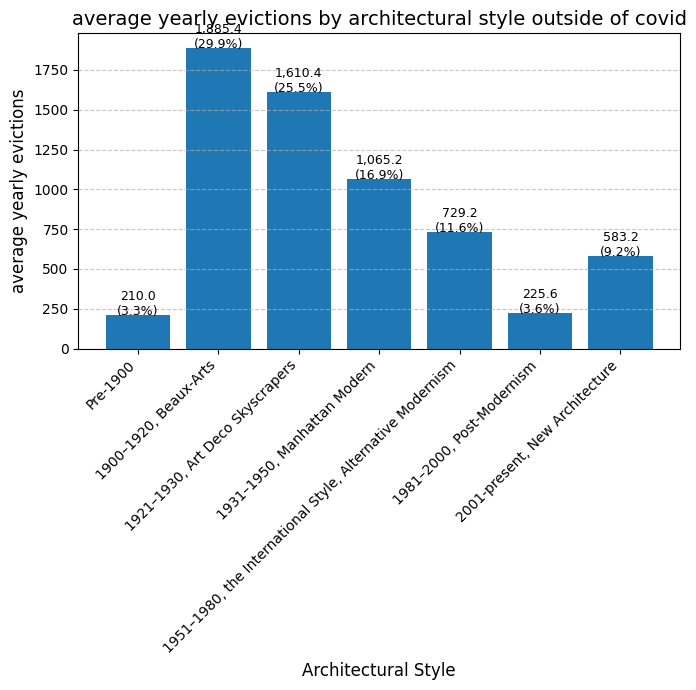

In [240]:
category_data['yearly_evictions'] = category_data['total_evictions'] / 5
total_yearly_evictions = category_data['yearly_evictions'].sum()
category_data['percentage'] = (category_data['yearly_evictions_per_cat'] / total_yearly_evictions) * 100

plt.figure(figsize=(7, 7))
bars = plt.bar(category_data['architectural_style'], category_data['yearly_evictions_per_cat'])
for i, (value, percentage) in enumerate(zip(category_data['yearly_evictions_per_cat'],
                                            category_data['percentage'])):
    plt.text(i, value + (value * 0.00005),
             f"{value:,.1f}\n({percentage:.1f}%)",
             ha='center', fontsize=9)
plt.xlabel('Architectural Style', fontsize=12)
plt.ylabel('average yearly evictions', fontsize=12)
plt.title('average yearly evictions by architectural style outside of covid', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

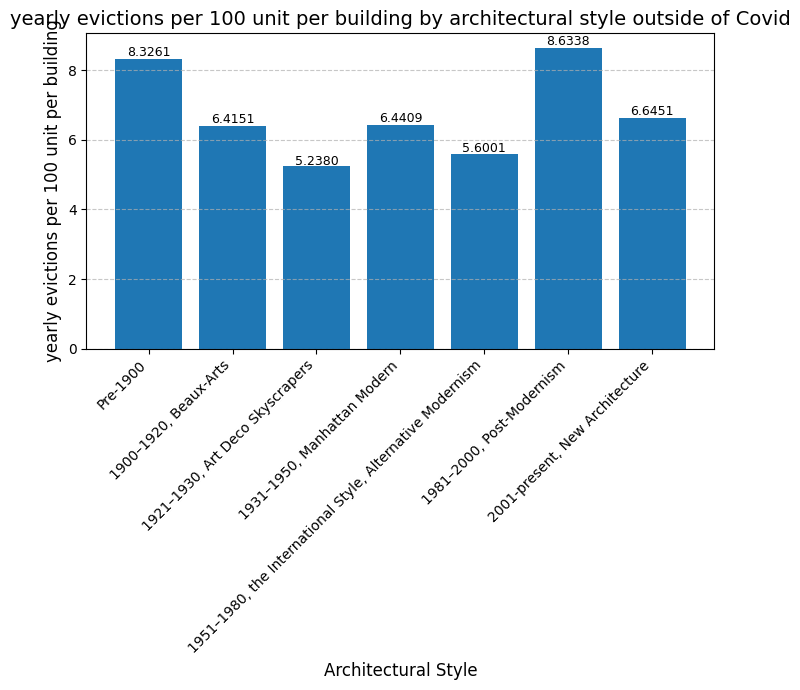

In [241]:
plt.figure(figsize=(7, 7))
bars = plt.bar(category_data['architectural_style'], category_data['yearly_evictions_per_100unit'])
for i, value in enumerate(category_data['yearly_evictions_per_100unit']):
    plt.text(i, value + (value * 0.01),
             f"{value:.4f}",
             ha='center', fontsize=9)

plt.xlabel('Architectural Style', fontsize=12)
plt.ylabel('yearly evictions per 100 unit per building', fontsize=12)
plt.title('yearly evictions per 100 unit per building by architectural style outside of Covid', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

In [242]:
print("ranked list of yearly evictions per building:")
sorted_data = category_data.sort_values('yearly_evictions_per_100unit', ascending=False)
for i in range(len(sorted_data)):
    category = sorted_data.iloc[i]['architectural_style']
    rate = sorted_data.iloc[i]['yearly_evictions_per_100unit']
    print(f"{i+1}. {category}: {rate:.4f}")

ranked list of yearly evictions per building:
1. 1981–2000, Post-Modernism: 8.6338
2. Pre-1900: 8.3261
3. 2001-present, New Architecture: 6.6451
4. 1931–1950, Manhattan Modern: 6.4409
5. 1900–1920, Beaux-Arts: 6.4151
6. 1951–1980, the International Style, Alternative Modernism: 5.6001
7. 1921–1930, Art Deco Skyscrapers: 5.2380


There is no linear relationship between the reviction rates and architectural style, but it leads to some interesting observations. The highest eviction rates are in Post_Modernism buildings (1981-2000) at 8.63 evictions per 100 unit per building per year. The lowest rates are at Art Demo Skyscrapers. Some possibile explainations for these observations are: the high rate in post0modernism buildings might reflect the gentrification dynamics during specific real estate booms, maintenance issues, different ownership patters, or location factors. The lower rates in mid-centuray buildings might indicate more stable tenant populations or more likely to be comdo/co-op or different management approaches. Other factors might be closed correlated with architectural styles would be: building locations, typical unit sizes in buildings of different eras, rent regulation status, or management types(individual landlords, small llcs, or large corporations).

### Since architectural stypes are closely related to the age of the buildings, we will take a closer look at the age of the building.

In [243]:
building_evictions_clean.building_age.unique()

array([  27.,   42.,   23.,   21.,   56.,  127.,   69.,  121.,   67.,
         96.,  104.,   99.,   53.,  110.,  117.,    6.,  125.,   22.,
         94.,   54.,   52.,   10.,   16.,  120.,    9.,   19.,   13.,
        143.,   75.,   65.,   61.,   50.,  165.,   37.,  155.,  105.,
         80.,  116.,   24.,   20.,  166.,  145.,  115.,  135.,    8.,
        173.,   18.,  133.,  113.,   63.,   47.,   46.,   30.,   90.,
         62.,   71.,   70.,   85.,  119.,   95.,   59.,   49.,  111.,
         15.,    7.,   25.,   77.,   36.,   31.,   64.,   33.,  118.,
         45.,  106.,  100.,  112.,   12.,   11.,   55.,  132.,  134.,
        103.,  154.,  162.,   40.,  180.,  122.,  130.,  124.,  126.,
         43.,  146.,  131.,   98.,   34.,  195.,  137.,   97.,   39.,
         66.,   58.,  136.,  194.,  147.,  138.,  139.,  141.,  123.,
        192.,   73.,  102.,  179.,  196.,  197.,  153.,  101.,  109.,
        140.,  189.,  186.,  114.,  129.,   76.,   86.,   14.,   17.,
         60.,  169.,

In [244]:
building_evictions_clean.columns

Index(['bbl_clean', 'average_year_eviction_count', 'eviction_count',
       'unitsres', 'decade', 'building_category', 'building_type', 'is_llc',
       'yearbuilt', 'bldgclass', 'numfloors', 'bldgarea', 'is_condo',
       'floor_category', 'rent_era', 'architectural_style', 'economic_period',
       'residential_units_category', 'building_size_category', 'size_quartile',
       'eviction_rate_per_unit', 'building_age', 'evictions_per_unit',
       'evictions_per_100_units'],
      dtype='object')

## 4. By Decades

In [245]:
category_data = build_category_dataframes(bbl_cleaned, building_evictions_clean, 'decade')
category_data

,decade,total_evictions,eviction_percentage,building_count,building_percentage,yearly_evictions_per_cat,evictions_per_100_units,yearly_evictions_per_100unit
0,1900-1909,2614,0.082874,39141,5.197497,522.8,28.013824,5.602765
1,1910-1919,4071,0.129066,59065,7.843187,814.2,25.558833,5.111767
2,1920-1929,8379,0.265646,168261,22.343223,1675.8,27.612533,5.522507
3,1930-1939,5796,0.183755,119817,15.910389,1159.2,31.643501,6.328700
4,1940-1949,1308,0.041469,63636,8.450166,261.6,43.192333,8.638467
5,1950-1959,1582,0.050155,73472,9.756279,316.4,37.320597,7.464119
6,1960-1969,1885,0.059762,57993,7.700837,377.0,29.315370,5.863074
7,1970-1979,750,0.023778,30151,4.003723,150.0,28.709238,5.741848
8,1980-1989,487,0.015440,24597,3.266213,97.4,34.069122,6.813824
9,1990-1999,594,0.018832,26336,3.497133,118.8,49.643271,9.928654


In [247]:
category_data.decade.unique()

array(['1900-1909', '1910-1919', '1920-1929', '1930-1939', '1940-1949',
       '1950-1959', '1960-1969', '1970-1979', '1980-1989', '1990-1999',
       '2000-2009', '2010-2019', 'Pre-1900'], dtype=object)

In [248]:
order = ['Pre-1900', '1900-1909', '1910-1919', '1920-1929', '1930-1939', '1940-1949',
       '1950-1959', '1960-1969', '1970-1979', '1980-1989', '1990-1999',
       '2000-2009', '2010-2019']
category_data['decade'] = pd.Categorical(category_data['decade'], categories= order, ordered=True)
category_data = category_data.sort_values('decade')

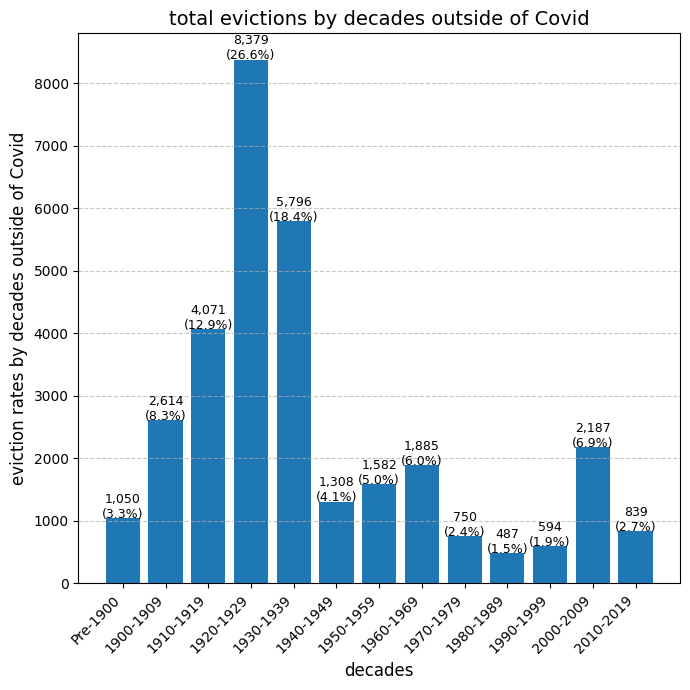

In [250]:
total_all_evictions = category_data['total_evictions'].sum()
# category_data['percentage'] = (category_data['total_evictions'] / total_all_evictions) * 100

plt.figure(figsize=(7, 7))
bars = plt.bar(category_data['decade'], category_data['total_evictions'])
for i, (value, percentage) in enumerate(zip(category_data['total_evictions'],
                                           category_data['eviction_percentage']*100)):
    plt.text(i, value + (value * 0.0001),
             f"{value:,.0f}\n({percentage:.1f}%)",
             ha='center', fontsize=9)
plt.xlabel('different decades', fontsize=12)
plt.ylabel('eviction rates by decades outside of Covid', fontsize=12)
plt.title('total evictions by decades outside of Covid', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

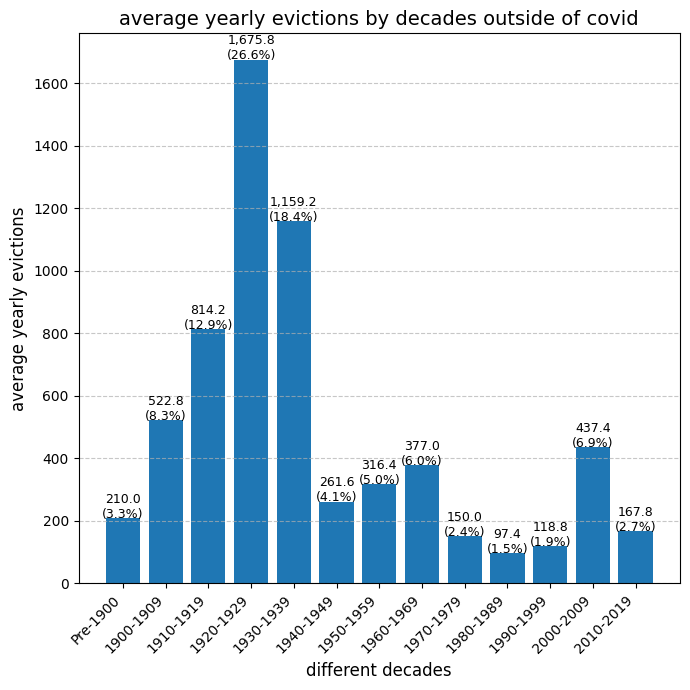

In [252]:
category_data['yearly_evictions'] = category_data['total_evictions'] / 5
total_yearly_evictions = category_data['yearly_evictions'].sum()
category_data['percentage'] = (category_data['yearly_evictions_per_cat'] / total_yearly_evictions) * 100

plt.figure(figsize=(7, 7))
bars = plt.bar(category_data['decade'], category_data['yearly_evictions_per_cat'])
for i, (value, percentage) in enumerate(zip(category_data['yearly_evictions_per_cat'],
                                            category_data['percentage'])):
    plt.text(i, value + (value * 0.00005),
             f"{value:,.1f}\n({percentage:.1f}%)",
             ha='center', fontsize=9)
plt.xlabel('different decades', fontsize=12)
plt.ylabel('average yearly evictions', fontsize=12)
plt.title('average yearly evictions by decades outside of covid', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

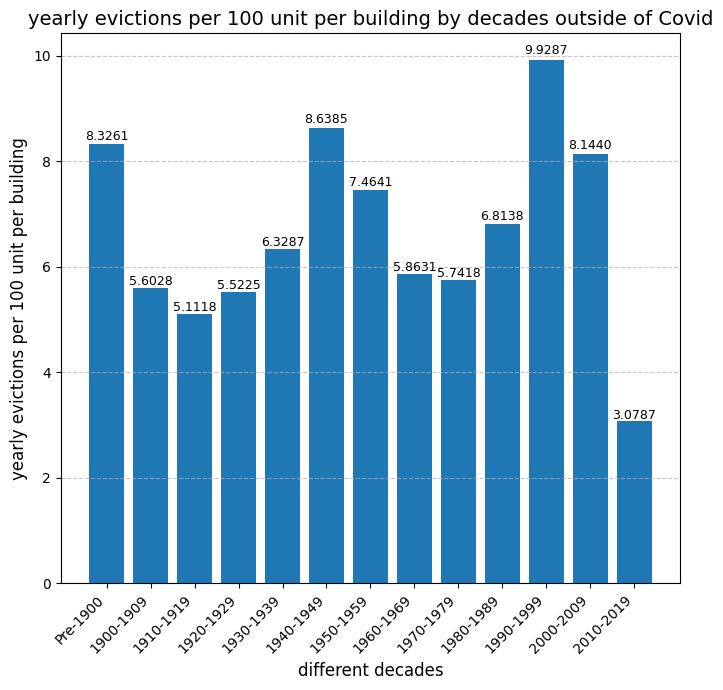

In [255]:
plt.figure(figsize=(7, 7))
bars = plt.bar(category_data['decade'], category_data['yearly_evictions_per_100unit'])
for i, value in enumerate(category_data['yearly_evictions_per_100unit']):
    plt.text(i, value + (value * 0.01),
             f"{value:.4f}",
             ha='center', fontsize=9)

plt.xlabel('different decades', fontsize=12)
plt.ylabel('yearly evictions per 100 unit per building', fontsize=12)
plt.title('yearly evictions per 100 unit per building by decades outside of Covid', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

In [256]:
print("ranked list of yearly evictions per building:")
sorted_data = category_data.sort_values('yearly_evictions_per_100unit', ascending=False)
for i in range(len(sorted_data)):
    category = sorted_data.iloc[i]['decade']
    rate = sorted_data.iloc[i]['yearly_evictions_per_100unit']
    print(f"{i+1}. {category}: {rate:.4f}")

ranked list of yearly evictions per building:
1. 1990-1999: 9.9287
2. 1940-1949: 8.6385
3. Pre-1900: 8.3261
4. 2000-2009: 8.1440
5. 1950-1959: 7.4641
6. 1980-1989: 6.8138
7. 1930-1939: 6.3287
8. 1960-1969: 5.8631
9. 1970-1979: 5.7418
10. 1900-1909: 5.6028
11. 1920-1929: 5.5225
12. 1910-1919: 5.1118
13. 2010-2019: 3.0787


This result further confirms that these is no simple linear relationship between building age and eviction rates. It is not simply that older buildings hae more evictions or vice versa. Therefore, this could suggest that beyond simple building age are at play. The high rates in 1990s buildings might reflect specific construction or ownership patterns from that era. The relatively high rates in very old buildings, such as pre-1900, could relate to maintenance issues or other characteristics of historic properties. The notably low rate in 2010s buildings might reflect newer building codes, different tenant demographics, or different management practices in more recently constructed buildings. \
This finding also further confirms the previous numerical correlation analysis.

## 5. Floor Category

In [257]:
category_data = build_category_dataframes(bbl_cleaned, building_evictions_clean, 'floor_category')
category_data # low-rise: <= 3 floors, mid-rise: 4~6 floors, high-rise: > 6 floors

,floor_category,total_evictions,eviction_percentage,building_count,building_percentage,yearly_evictions_per_cat,evictions_per_100_units,yearly_evictions_per_100unit
0,high-rise,2211,0.070090,7194,0.955239,442.2,2.443738,0.488748
1,low-rise,15973,0.506356,695209,92.311747,3194.6,55.715444,11.143089
2,mid-rise,13361,0.423554,50707,6.733014,2672.2,6.048122,1.209624


In [258]:
order = ['low-rise', 'mid-rise', 'high-rise', ]
category_data['floor_category'] = pd.Categorical(category_data['floor_category'], categories= order, ordered=True)
category_data = category_data.sort_values('floor_category')
category_data

,floor_category,total_evictions,eviction_percentage,building_count,building_percentage,yearly_evictions_per_cat,evictions_per_100_units,yearly_evictions_per_100unit
1,low-rise,15973,0.506356,695209,92.311747,3194.6,55.715444,11.143089
2,mid-rise,13361,0.423554,50707,6.733014,2672.2,6.048122,1.209624
0,high-rise,2211,0.070090,7194,0.955239,442.2,2.443738,0.488748


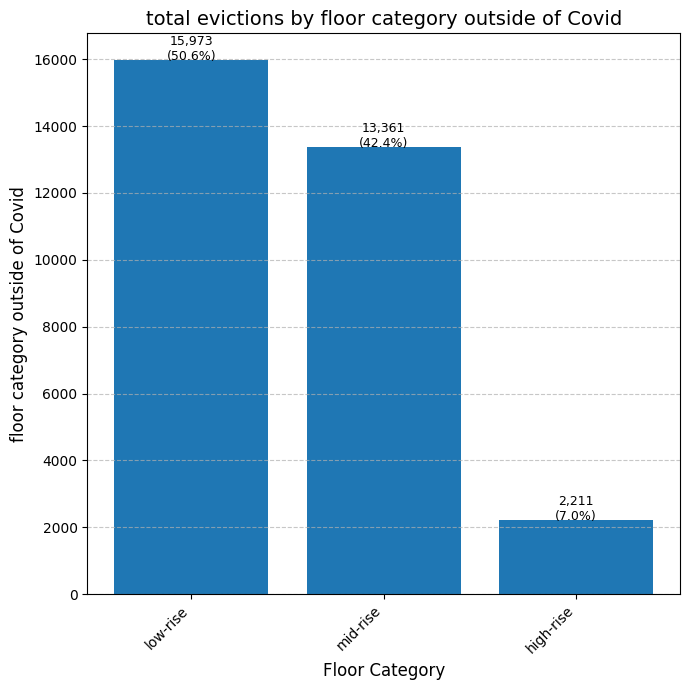

In [259]:
total_all_evictions = category_data['total_evictions'].sum()
# category_data['percentage'] = (category_data['total_evictions'] / total_all_evictions) * 100

plt.figure(figsize=(7, 7))
bars = plt.bar(category_data['floor_category'], category_data['total_evictions'])
for i, (value, percentage) in enumerate(zip(category_data['total_evictions'],
                                           category_data['eviction_percentage']*100)):
    plt.text(i, value + (value * 0.0001),
             f"{value:,.0f}\n({percentage:.1f}%)",
             ha='center', fontsize=9)
plt.xlabel('Floor Category', fontsize=12)
plt.ylabel('floor category outside of Covid', fontsize=12)
plt.title('total evictions by floor category outside of Covid', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

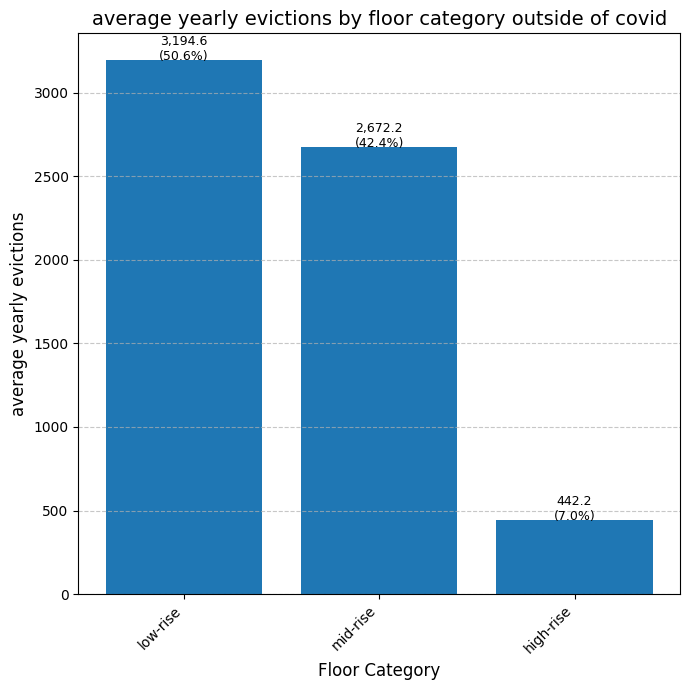

In [260]:
category_data['yearly_evictions'] = category_data['total_evictions'] / 5
total_yearly_evictions = category_data['yearly_evictions'].sum()
category_data['percentage'] = (category_data['yearly_evictions_per_cat'] / total_yearly_evictions) * 100

plt.figure(figsize=(7, 7))
bars = plt.bar(category_data['floor_category'], category_data['yearly_evictions_per_cat'])
for i, (value, percentage) in enumerate(zip(category_data['yearly_evictions_per_cat'],
                                            category_data['percentage'])):
    plt.text(i, value + (value * 0.00005),
             f"{value:,.1f}\n({percentage:.1f}%)",
             ha='center', fontsize=9)
plt.xlabel('Floor Category', fontsize=12)
plt.ylabel('average yearly evictions', fontsize=12)
plt.title('average yearly evictions by floor category outside of covid', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

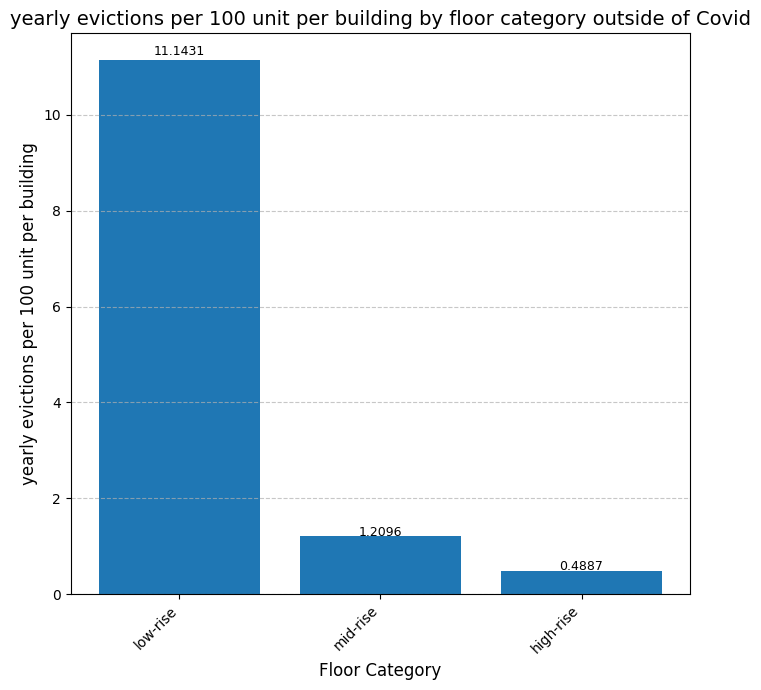

In [261]:
plt.figure(figsize=(7, 7))
bars = plt.bar(category_data['floor_category'], category_data['yearly_evictions_per_100unit'])
for i, value in enumerate(category_data['yearly_evictions_per_100unit']):
    plt.text(i, value + (value * 0.01),
             f"{value:.4f}",
             ha='center', fontsize=9)

plt.xlabel('Floor Category', fontsize=12)
plt.ylabel('yearly evictions per 100 unit per building', fontsize=12)
plt.title('yearly evictions per 100 unit per building by floor category outside of Covid', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

#### Makes sense

In [262]:
print("ranked list of yearly evictions per building:")
sorted_data = category_data.sort_values('yearly_evictions_per_100unit', ascending=False)
for i in range(len(sorted_data)):
    category = sorted_data.iloc[i]['floor_category']
    rate = sorted_data.iloc[i]['yearly_evictions_per_100unit']
    print(f"{i+1}. {category}: {rate:.4f}")

ranked list of yearly evictions per building:
1. low-rise: 11.1431
2. mid-rise: 1.2096
3. high-rise: 0.4887


Makes sense, with the previous numerical correlation test.


## 6.Residential Units Category

In [263]:
category_data = build_category_dataframes(bbl_cleaned, building_evictions_clean, 'residential_units_category')
category_data.residential_units_category.unique()

array(['100+ units', '2-unit', '21-100 units', '3-5 units', '6-20 units',
       'single-unit'], dtype=object)

In [264]:
category_data

,residential_units_category,total_evictions,eviction_percentage,building_count,building_percentage,yearly_evictions_per_cat,evictions_per_100_units,yearly_evictions_per_100unit
0,100+ units,2203,0.069837,3445,0.457436,440.6,0.985825,0.197165
1,2-unit,6823,0.216294,266988,35.451395,1364.6,61.922908,12.384582
2,21-100 units,9123,0.289206,18111,2.404828,1824.6,3.367037,0.673407
3,3-5 units,5246,0.166302,103859,13.790681,1049.2,36.783078,7.356616
4,6-20 units,5983,0.189666,40058,5.319011,1196.6,11.771114,2.354223
5,single-unit,2167,0.068696,320649,42.576649,433.4,118.770189,23.754038


In [265]:
order = ['single-unit', '2-unit', '3-5 units', '6-20 units', '21-100 units', '100+ units']
category_data['residential_units_category'] = pd.Categorical(category_data['residential_units_category'], categories= order, ordered=True)
category_data = category_data.sort_values('residential_units_category')

In [266]:
category_data

,residential_units_category,total_evictions,eviction_percentage,building_count,building_percentage,yearly_evictions_per_cat,evictions_per_100_units,yearly_evictions_per_100unit
5,single-unit,2167,0.068696,320649,42.576649,433.4,118.770189,23.754038
1,2-unit,6823,0.216294,266988,35.451395,1364.6,61.922908,12.384582
3,3-5 units,5246,0.166302,103859,13.790681,1049.2,36.783078,7.356616
4,6-20 units,5983,0.189666,40058,5.319011,1196.6,11.771114,2.354223
2,21-100 units,9123,0.289206,18111,2.404828,1824.6,3.367037,0.673407
0,100+ units,2203,0.069837,3445,0.457436,440.6,0.985825,0.197165


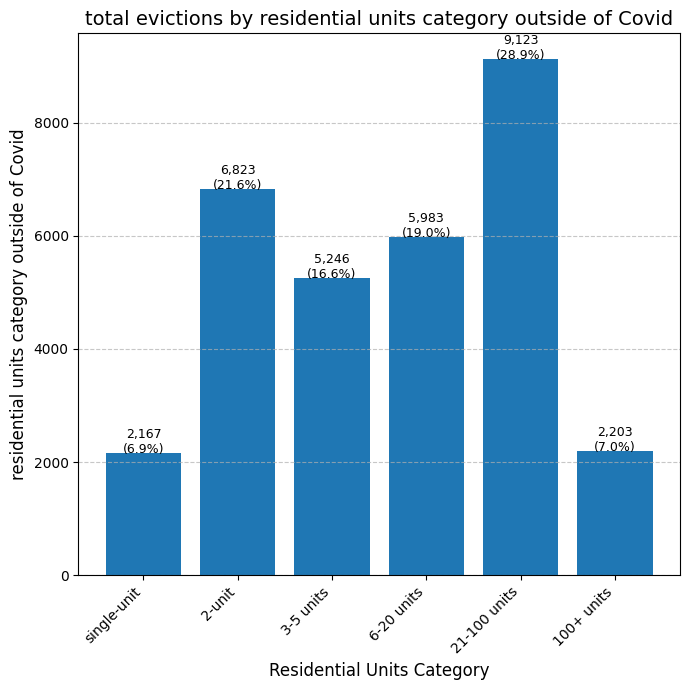

In [267]:
total_all_evictions = category_data['total_evictions'].sum()
# category_data['percentage'] = (category_data['total_evictions'] / total_all_evictions) * 100

plt.figure(figsize=(7, 7))
bars = plt.bar(category_data['residential_units_category'], category_data['total_evictions'])
for i, (value, percentage) in enumerate(zip(category_data['total_evictions'],
                                           category_data['eviction_percentage']*100)):
    plt.text(i, value + (value * 0.0001),
             f"{value:,.0f}\n({percentage:.1f}%)",
             ha='center', fontsize=9)
plt.xlabel('Residential Units Category', fontsize=12)
plt.ylabel('residential units category outside of Covid', fontsize=12)
plt.title('total evictions by residential units category outside of Covid', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

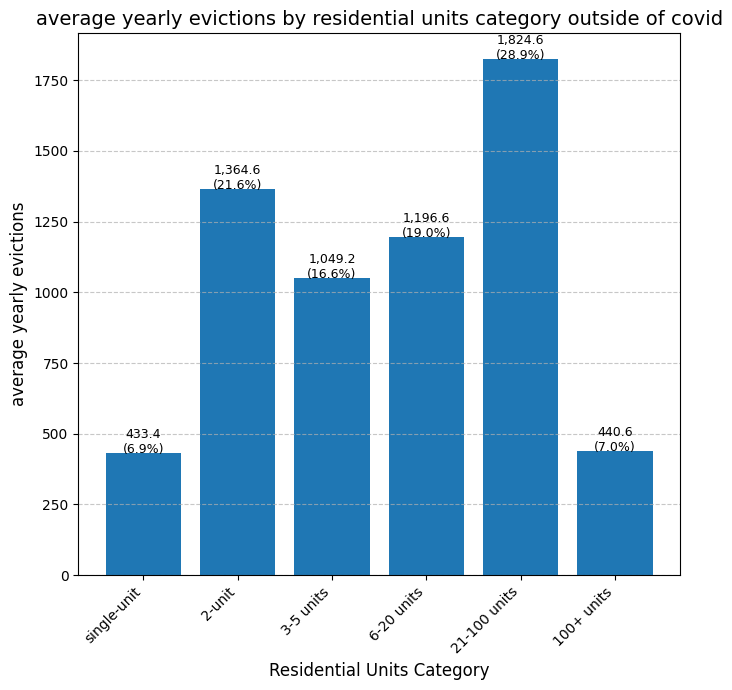

In [268]:
category_data['yearly_evictions'] = category_data['total_evictions'] / 5
total_yearly_evictions = category_data['yearly_evictions'].sum()
category_data['percentage'] = (category_data['yearly_evictions_per_cat'] / total_yearly_evictions) * 100

plt.figure(figsize=(7, 7))
bars = plt.bar(category_data['residential_units_category'], category_data['yearly_evictions_per_cat'])
for i, (value, percentage) in enumerate(zip(category_data['yearly_evictions_per_cat'],
                                            category_data['percentage'])):
    plt.text(i, value + (value * 0.00005),
             f"{value:,.1f}\n({percentage:.1f}%)",
             ha='center', fontsize=9)
plt.xlabel('Residential Units Category', fontsize=12)
plt.ylabel('average yearly evictions', fontsize=12)
plt.title('average yearly evictions by residential units category outside of covid', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

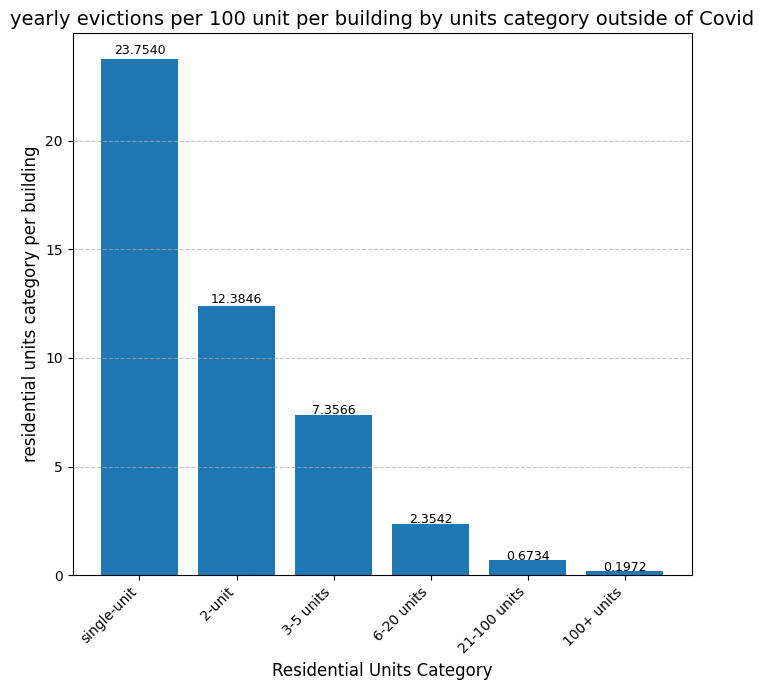

In [269]:
plt.figure(figsize=(7, 7))
bars = plt.bar(category_data['residential_units_category'], category_data['yearly_evictions_per_100unit'])
for i, value in enumerate(category_data['yearly_evictions_per_100unit']):
    plt.text(i, value + (value * 0.01),
             f"{value:.4f}",
             ha='center', fontsize=9)

plt.xlabel('Residential Units Category', fontsize=12)
plt.ylabel('residential units category per building', fontsize=12)
plt.title('yearly evictions per 100 unit per building by units category outside of Covid', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

In [270]:
print("ranked list of yearly evictions per building:")
sorted_data = category_data.sort_values('yearly_evictions_per_100unit', ascending=False)
for i in range(len(sorted_data)):
    category = sorted_data.iloc[i]['residential_units_category']
    rate = sorted_data.iloc[i]['yearly_evictions_per_100unit']
    print(f"{i+1}. {category}: {rate:.4f}")

ranked list of yearly evictions per building:
1. single-unit: 23.7540
2. 2-unit: 12.3846
3. 3-5 units: 7.3566
4. 6-20 units: 2.3542
5. 21-100 units: 0.6734
6. 100+ units: 0.1972


There is a strong inverse relationship between the number of units in a building and the eviction rate per unit in a building. \
Further analysis combined with building size category, see below.

## 7. Building Size Category

In [271]:
category_data = build_category_dataframes(bbl_cleaned, building_evictions_clean, 'building_size_category')
category_data.building_size_category.unique()

array(['large', 'medium', 'medium-small', 'mega', 'small', 'tiny',
       'very large', 'very small'], dtype=object)

In [272]:
category_data

,building_size_category,total_evictions,eviction_percentage,building_count,building_percentage,yearly_evictions_per_cat,evictions_per_100_units,yearly_evictions_per_100unit
0,large,4461,0.141417,14761,1.960006,892.2,6.600602,1.320120
1,medium,3087,0.097860,31069,4.125427,617.4,15.285105,3.057021
2,medium-small,4561,0.144587,105397,13.994901,912.2,38.044721,7.608944
3,mega,2152,0.068220,3740,0.496607,430.4,1.037580,0.207516
4,small,5306,0.168204,206682,27.443800,1061.2,55.820130,11.164026
5,tiny,315,0.009986,29398,3.903547,63.0,109.459408,21.891882
6,very large,7027,0.222761,13011,1.727636,1405.4,2.889329,0.577866
7,very small,4636,0.146965,349052,46.348077,927.2,80.415220,16.083044


In [273]:
order = ['tiny', 'very small', 'small','medium-small', 'medium','large', 'very large','mega']
category_data['building_size_category'] = pd.Categorical(category_data['building_size_category'], categories= order, ordered=True)
category_data = category_data.sort_values('building_size_category')

In [274]:
category_data

,building_size_category,total_evictions,eviction_percentage,building_count,building_percentage,yearly_evictions_per_cat,evictions_per_100_units,yearly_evictions_per_100unit
5,tiny,315,0.009986,29398,3.903547,63.0,109.459408,21.891882
7,very small,4636,0.146965,349052,46.348077,927.2,80.415220,16.083044
4,small,5306,0.168204,206682,27.443800,1061.2,55.820130,11.164026
2,medium-small,4561,0.144587,105397,13.994901,912.2,38.044721,7.608944
1,medium,3087,0.097860,31069,4.125427,617.4,15.285105,3.057021
0,large,4461,0.141417,14761,1.960006,892.2,6.600602,1.320120
6,very large,7027,0.222761,13011,1.727636,1405.4,2.889329,0.577866
3,mega,2152,0.068220,3740,0.496607,430.4,1.037580,0.207516


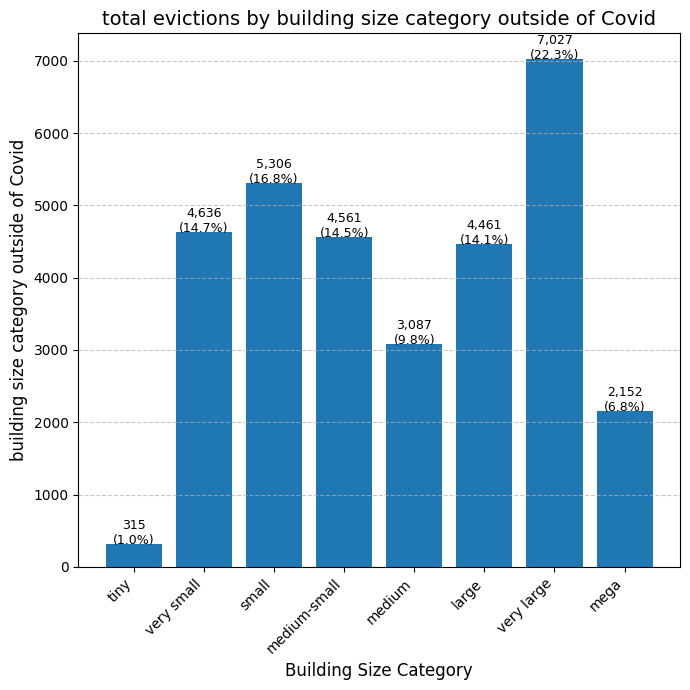

In [275]:
total_all_evictions = category_data['total_evictions'].sum()
# category_data['percentage'] = (category_data['total_evictions'] / total_all_evictions) * 100

plt.figure(figsize=(7, 7))
bars = plt.bar(category_data['building_size_category'], category_data['total_evictions'])
for i, (value, percentage) in enumerate(zip(category_data['total_evictions'],
                                           category_data['eviction_percentage']*100)):
    plt.text(i, value + (value * 0.0001),
             f"{value:,.0f}\n({percentage:.1f}%)",
             ha='center', fontsize=9)
plt.xlabel('Building Size Category', fontsize=12)
plt.ylabel('building size category outside of Covid', fontsize=12)
plt.title('total evictions by building size category outside of Covid', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

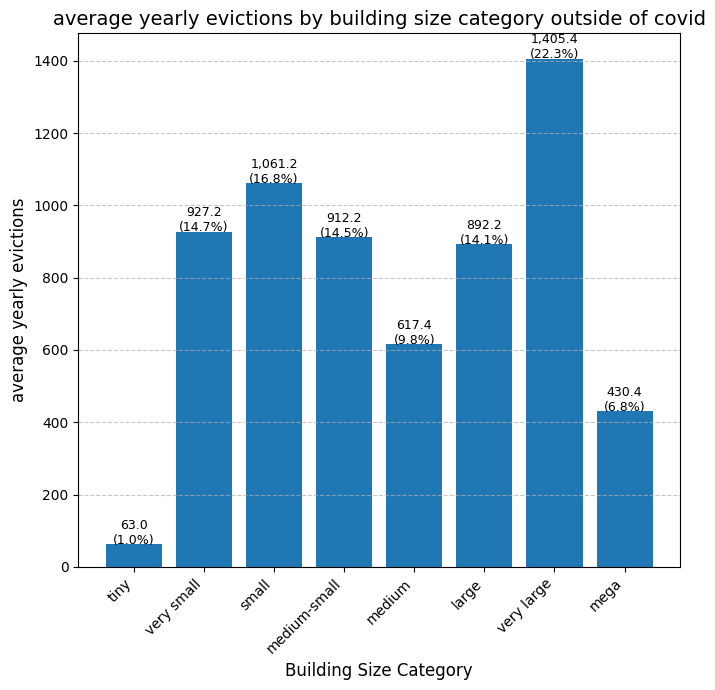

In [276]:
category_data['yearly_evictions'] = category_data['total_evictions'] / 5
total_yearly_evictions = category_data['yearly_evictions'].sum()
category_data['percentage'] = (category_data['yearly_evictions_per_cat'] / total_yearly_evictions) * 100

plt.figure(figsize=(7, 7))
bars = plt.bar(category_data['building_size_category'], category_data['yearly_evictions_per_cat'])
for i, (value, percentage) in enumerate(zip(category_data['yearly_evictions_per_cat'],
                                            category_data['percentage'])):
    plt.text(i, value + (value * 0.0005),
             f"{value:,.1f}\n({percentage:.1f}%)",
             ha='center', fontsize=9)
plt.xlabel('Building Size Category', fontsize=12)
plt.ylabel('average yearly evictions', fontsize=12)
plt.title('average yearly evictions by building size category outside of covid', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

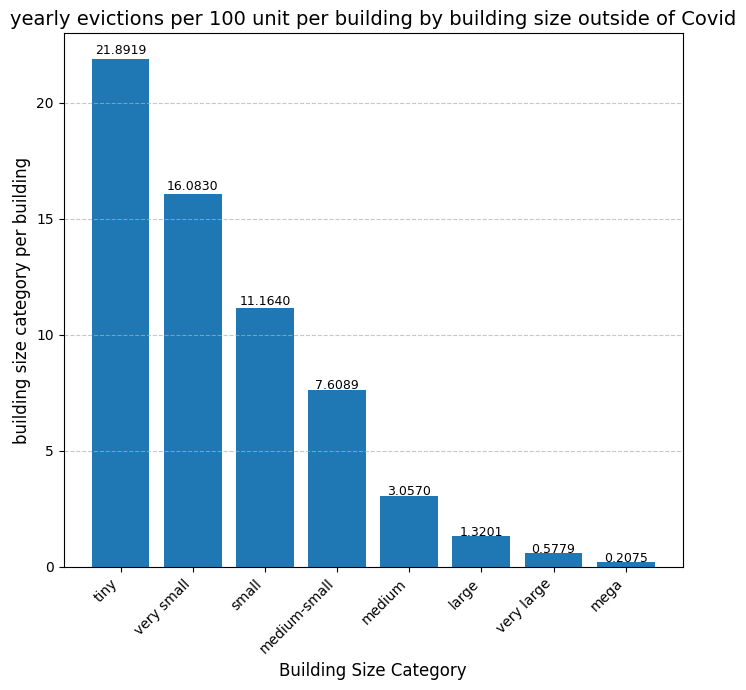

In [277]:
plt.figure(figsize=(7, 7))
bars = plt.bar(category_data['building_size_category'], category_data['yearly_evictions_per_100unit'])
for i, value in enumerate(category_data['yearly_evictions_per_100unit']):
    plt.text(i, value + (value * 0.01),
             f"{value:.4f}",
             ha='center', fontsize=9)

plt.xlabel('Building Size Category', fontsize=12)
plt.ylabel('building size category per building', fontsize=12)
plt.title('yearly evictions per 100 unit per building by building size outside of Covid', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

In [278]:
print("ranked list of yearly evictions per building:")
sorted_data = category_data.sort_values('yearly_evictions_per_100unit', ascending=False)
for i in range(len(sorted_data)):
    category = sorted_data.iloc[i]['building_size_category']
    rate = sorted_data.iloc[i]['yearly_evictions_per_100unit']
    print(f"{i+1}. {category}: {rate:.4f}")

ranked list of yearly evictions per building:
1. tiny: 21.8919
2. very small: 16.0830
3. small: 11.1640
4. medium-small: 7.6089
5. medium: 3.0570
6. large: 1.3201
7. very large: 0.5779
8. mega: 0.2075


Tiny buildings have eviction rates that are about more than 20 times higher than large buildings (21.89 and 1.32). An inverse relationship with building size and eviction rates per unit shows that larger the residential area of the building has, the less likely residents will experience evictions. This may be due to the fact that smaller buildings are more like to be controlled by one llc who has more flexibility when it comes to rent, whereas larger buildings are managed by more formal companies who specialize in building management. Larger buildings tend to have stricter tenant screening process than companies managing smaller companies. Tenant demographics may also be different, as people with higher and more stable incomes may prefer to live in high-risers that have more units and areas.

In summary, the factors that have the strongest (inverse) correlation are building size and building height. The taller and larger the buildings, the lower the eviction rate per unit per building.